In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [431]:
# reading dataset

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head(2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0


In [432]:
df_test.head(2)

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0


## Check for null and unique values for test and train sets.

In [433]:
# Check for null and unique values for train sets

df_train.isna().any()[df_train.isna().any()==True]
df_train.drop_duplicates(inplace=True)

In [434]:
# Check for null and unique values for test sets

df_test.isna().any()[df_test.isna().any()==True]
df_test.drop_duplicates(inplace=True)

## If for any column(s), the variance is equal to zero, then you need to remove those variable(s)

In [435]:
unique_cols=[]
for x in df_train.columns[2:]:
    if len(df_train[x].unique())==1:
        unique_cols.append(x)
unique_cols

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

In [436]:
print("Shape before removing unique columns",df_train.shape)
df_train.drop(unique_cols, axis=1, inplace=True)
print("Shape after removing unique columns",df_train.shape)

Shape before removing unique columns (4209, 378)
Shape after removing unique columns (4209, 366)


In [437]:
df_test.drop(unique_cols, axis=1, inplace=True)

## Apply label encoder.

In [438]:
# checking if unique values in test data is a subset of that in train data column wise

z = df_train.iloc[:,2].unique()
for x in df_test.iloc[:,1].unique():
    if len(np.where(z==x)[0])==0:
        print(x)

av
ag
an
ae
p
bb


In [439]:
df_train.columns[2:10]

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [440]:
# applying unicode lable encoding since unique values in test data is not a subset of that in train data col wise

for col in df_train.columns[2:10]:
    mapper = lambda x: sum([ord(digit) for digit in x])
    df_train[col] = df_train[col].apply(mapper)
    df_test[col] = df_test[col].apply(mapper)
    
df_train.head(2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,107,118,213,97,100,117,106,111,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,107,116,215,101,100,121,108,111,...,1,0,0,0,0,0,0,0,0,0


In [441]:
df_test.head(2)

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,219,118,110,102,100,116,97,119,0,...,0,0,0,1,0,0,0,0,0,0
1,2,116,98,202,97,100,98,103,121,0,...,0,0,1,0,0,0,0,0,0,0


## Perform dimensionality reduction

In [442]:
df_train_x = df_train.iloc[:,2:]
df_train_y = df_train.iloc[:,1]
df_test_x = df_test.iloc[:,1:]

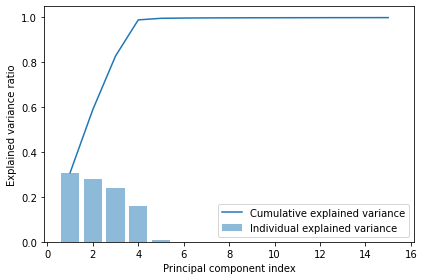

In [443]:
# pca dimentions selection from explained variance plot
from sklearn.decomposition import PCA

n_comp = 15
pca = PCA(n_components=n_comp, random_state=420)
pca.fit(df_train_x)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues,label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [444]:
# selection n_components=4 based on variance plot

n_comp = 4
pca = PCA(n_components=n_comp, random_state=420)
pca_transform_train = pca.fit_transform(df_train_x)
pca_transform_test = pca.transform(df_test_x)

## Predict your test_df values using XGBoost

In [445]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [446]:
# creating xgb modle and splitting trian dataset into train and validation set to text accuracy of model

model = xgb.XGBRegressor(objective ='reg:linear',
                  n_estimators = 100, seed = 123)
x_train, x_validation, y_train, y_validation = train_test_split(pca_transform_train, df_train_y, test_size=0.3)

model.fit(x_train, y_train)

[12:46:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=123, reg_alpha=0, ...)

In [447]:
# evaluate accauracy of model on validation set
RMSE = np.sqrt(mean_squared_error(y_validation, model.predict(x_validation)))
print("RMSE", RMSE)
print("R2 score", r2_score(y_validation, model.predict(x_validation)))

RMSE 9.748573591778749
R2 score 0.3523244766780733


In [448]:
# predictions on test data

model.predict(pca_transform_test)

array([ 83.14802 ,  96.73292 ,  88.02295 , ..., 100.86847 , 105.23959 ,
        99.129295], dtype=float32)